## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2024-01-16 16:17:04--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2024-01-16 16:17:05--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb6d2b19efcd60a93ddc1cd4d6e.dl.dropboxusercontent.com/cd/0/inline/CLfnP3IQx2WwPftFt_9wjLUB1J9WUSH_r_1_2IRYpH2ZylZiFLxTEBhCOOb21sQphCT0UYgjOw2mAJF-L_4DGbaZXOh9vu8vmbsbDnqnf77nCwB0cGsuJNdn5Ompz9KkdG4/file# [following]
--2024-01-16 16:17:05--  https://ucb6d2b19efcd60a93ddc1cd4d6e.dl.dropboxusercontent.com/cd/0/inline/CLfnP3IQx2WwPftFt_9wjLUB1J9WUSH_r_1_2IRYpH2ZylZiFLxTEBhCOOb21sQphCT0UYgjOw2mAJF-L_4DGbaZXOh9vu8

In [2]:
# Let's import pandas
import pandas as pd

In [5]:
# Load the data
path = '../data/data_000637.txt'
df = pd.read_csv(path)
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [38]:
# 1. 
# Choose amount of rows to read 
N = 10001
# Load data
df_N = pd.read_csv(path, nrows=N)
print('DataFrame shape:',df_N.shape)
df_N.head()

DataFrame shape: (10001, 6)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


In [51]:
# 2.
# Let's find out how many BX are there per ORBIT
print(r'Amount of BX per ORBIT:', df_N.BX_COUNTER.max())

Amount of BX per ORBIT: 3563


In [75]:
# 3. 
# Estimate how long the data taking took
# with the entire dataset

# Get first and last ORBIT values
first_last_ORBIT = (df.ORBIT_CNT.iloc[0], df.ORBIT_CNT.iloc[-1])
# Exclude these from the data and count the remaining amount 
# of ORBIT values
amount_ORBIT = df.loc[(df.ORBIT_CNT != first_last_ORBIT[0]) &\
                      (df.ORBIT_CNT != first_last_ORBIT[1]), 
                     'ORBIT_CNT'].unique().shape[0]

# Also get the amount of BX counts in first and last
# ORBIT rounds
amount_BX = 0
for val in first_last_ORBIT:
    BX_vals = df.loc[df.ORBIT_CNT == first_last_ORBIT[0], 'BX_COUNTER']
    count_BX = BX_vals.max() - BX_vals.min()
    amount_BX += count_BX
    
# Finally get total time in nanoseconds
total_time = (df.BX_COUNTER.max() * amount_ORBIT + amount_BX) * 25
print('Total measurement time: %.2f s' % (total_time*1e-9))

Total measurement time: 0.98 s


So the measurements took around one second.

In [76]:
# 4.
# Generate ns colum
df['ns_abs'] = 25 * (df.ORBIT_CNT * df.BX_COUNTER.max() + df.BX_COUNTER) + (df.TDC_MEAS - 25)
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ns_abs
0,1,0,123,3869200167,2374,26,344649004934876
1,1,0,124,3869200167,2374,27,344649004934877
2,1,0,63,3869200167,2553,28,344649004939353
3,1,0,64,3869200167,2558,19,344649004939469
4,1,0,64,3869200167,2760,25,344649004944525


In [77]:
# 5. 
# Replace values in the HEAD column 
# with a random choice between 0 and 1

# Import numpy
import numpy as np

In [85]:
# Generate values
rand_vals = np.random.choice([0,1], size=df.shape[0])

# Replace HEAD column
df['HEAD'] = rand_vals
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ns_abs
0,0,0,123,3869200167,2374,26,344649004934876
1,1,0,124,3869200167,2374,27,344649004934877
2,1,0,63,3869200167,2553,28,344649004939353
3,0,0,64,3869200167,2558,19,344649004939469
4,1,0,64,3869200167,2760,25,344649004944525


In [86]:
# 6. 
# Create a new dataframe that contain only the 
# rows with HEAD==1
new_df = df.loc[df.HEAD == 1].copy()
new_df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ns_abs
1,1,0,124,3869200167,2374,27,344649004934877
2,1,0,63,3869200167,2553,28,344649004939353
4,1,0,64,3869200167,2760,25,344649004944525
6,1,0,61,3869200167,2772,14,344649004944814
8,1,0,62,3869200167,2774,21,344649004944871


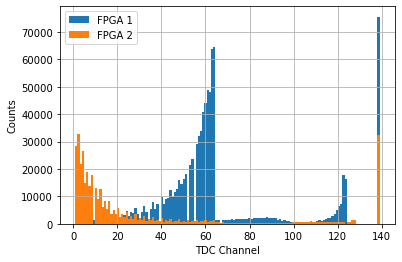

In [110]:
# 7. 
# Basically do a histogram for the column
# TDC_CHANNEL, for each FPGA
import matplotlib.pyplot as plt
# Split data, we won't copy because we won't 
# be doing any modifications to the data
df_fpga_1 = df.loc[df.FPGA == 0]
df_fpga_2 = df.loc[df.FPGA == 1]

# Easier to plot both histograms in the same fig
for i,d in enumerate([df_fpga_1, df_fpga_2]):
    d['TDC_CHANNEL'].hist(label='FPGA ' + str(i+1), 
                         bins=d['TDC_CHANNEL'].max())
plt.ylabel('Counts')
plt.xlabel('TDC Channel')
plt.legend();

In [125]:
# 8. 
# Let's find the top 3 TDC channels
# with most counts
channel_counts = df.groupby(by='TDC_CHANNEL').count()['HEAD']
top_3_noisy_ch = channel_counts.sort_values(ascending=False)[:3].index
top_3_noisy_ch = list(top_3_noisy_ch)
print('Top 3 noisy channels (descending order):', top_3_noisy_ch)

Top 3 noisy channels (descending order): [139, 64, 63]


In [132]:
# 9.
# First, get unique orbits
unique_orbits = df.ORBIT_CNT.unique()
print('Number of unique orbits:\n', unique_orbits.shape[0])

# Then, get unique orbits with at least one 
# measurement from channel 139
unique_orbits_ch139 = df.loc[df.TDC_CHANNEL==139,
                             'ORBIT_CNT'].unique()
print('\nNumber of unique orbits with at least\n'+\
      'one measurement from channel 139:\n', unique_orbits_ch139.shape[0])

Number of unique orbits:
 11001

Number of unique orbits with at least
one measurement from channel 139:
 10976
